In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE


from lstm_ae import LSTMAE, Encoder

In [17]:
df = pd.read_csv('data/sepsis_df.csv')
df = df.iloc[:,1:]

state_cols = ['gender', 'age', 'elixhauser', 're_admission',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'cumulated_balance']

df

,icustayid,gender,age,elixhauser,re_admission,died_in_hosp,died_in_hosp.1,Weight_kg,GCS,HR,...,HCO3,mechvent,Shock_Index,PaO2_FiO2,cumulated_balance,SOFA,max_dose_vaso,vaso_bin,input_4hourly,iv_bin
0,3,0,17639.0,0,0,0,0,78.699997,15.0,74.571429,...,28.750000,0,0.712142,240.000004,-7090.000,5,0.0,0,50.0,2
1,3,0,17639.0,0,0,0,0,78.699997,15.0,68.333333,...,28.750000,0,0.658106,240.000004,-7405.000,5,0.0,0,50.0,2
2,3,0,17639.0,0,0,0,0,78.699997,15.0,70.200000,...,28.750000,0,0.632432,240.000004,-7635.000,5,0.0,0,50.0,2
3,3,0,17639.0,0,0,0,0,79.499997,15.0,78.000000,...,28.750000,0,0.664395,240.000004,-7925.000,5,0.0,0,50.0,2
4,3,0,17639.0,0,0,0,0,79.699997,15.0,77.000000,...,28.750000,0,0.674256,240.000004,-8415.000,5,0.0,0,50.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264707,99995,0,8538.0,0,0,0,0,85.275132,15.0,89.200000,...,24.014109,0,0.607836,424.380952,-3676.417,0,0.0,0,0.0,0
264708,99995,0,8538.0,0,0,0,0,85.275132,15.0,85.166667,...,27.000000,0,0.575450,424.380952,-4376.417,0,0.0,0,0.0,0
264709,99995,0,8538.0,0,0,0,0,85.275132,15.0,75.800000,...,27.000000,0,0.515646,424.380952,-4796.417,0,0.0,0,0.0,0
264710,99995,0,8538.0,0,0,0,0,85.275132,15.0,72.000000,...,27.000000,0,0.496552,424.380952,-4796.417,4,0.0,0,0.0,0


In [ ]:
# state space representation using a recurrent (LSTM) autoencoder


class SepsisStateDataset(Dataset):
    """
    Torch dataset for sepsis state space data. Returns a tensor sequence of data 
    with size (seq_len, n_features). If the sequence is shorter than seq_len, it is
    padded with -1.
    """
    def __init__(self, df, state_cols, seq_len):
        self.state_cols = state_cols
        self.sequences = []
        self.lengths = []
        
        for icustayid, group in df.groupby('icustayid'):
            seq = group[state_cols].values.astype(np.float32)
            length = len(seq)

            # pad with -1 if necessary
            if length < seq_len:
                pad = np.full((seq_len - length, len(state_cols)), -1)
                seq = np.concatenate([seq, pad], axis=0)

            seq = torch.tensor(seq, dtype=torch.float32)

            self.sequences.append(seq)
            self.lengths.append(length)

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx]


def collate_fn(batch):
    sequences, lengths = zip(*batch)
    return torch.stack(sequences), torch.tensor(lengths)



SEQ_LEN = np.max(df['icustayid'].value_counts()) # max # of datapoints for any patient in sepsis_df | 20
BATCH_SIZE = 128
LR = 0.001
N_EPOCHS = 1000
N_FEATURES = len(state_cols)
HIDDEN_DIM = 256
LATENT_DIM = 20

cutoff = int(0.8 * len(df))
train_dataset = SepsisStateDataset(df[:cutoff], state_cols, SEQ_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_dataset = SepsisStateDataset(df[cutoff:], state_cols, SEQ_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMAE(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def masked_mse_loss(output, target, pad_value=-1):
    mask = (target != pad_value)
    diff = (output - target)[mask]
    return torch.sum(diff**2) / torch.sum(mask)

In [21]:
losses = []
model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0
    for batch, lengths in train_dataloader:
        batch = batch.to(device) # (batch_size, sequence_length, num_features)
        optimizer.zero_grad()
        output = model(batch, lengths) # (batch_size, sequence_length, num_features)
        loss = masked_mse_loss(output, batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    losses.append(total_loss)
    print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {total_loss/len(dataloader)}')


Epoch 1/1000, Loss: 19930852.59119497
Epoch 2/1000, Loss: 19846970.811320756
Epoch 3/1000, Loss: 19752905.427672956
Epoch 4/1000, Loss: 19735299.427672956
Epoch 5/1000, Loss: 19598469.679245282
Epoch 6/1000, Loss: 19604770.23899371
Epoch 7/1000, Loss: 19510061.496855345
Epoch 8/1000, Loss: 19493287.012578618
Epoch 9/1000, Loss: 19540366.150943395
Epoch 10/1000, Loss: 19406008.182389937
Epoch 11/1000, Loss: 19401674.698113207
Epoch 12/1000, Loss: 19297590.3081761
Epoch 13/1000, Loss: 19298278.16981132
Epoch 14/1000, Loss: 19182430.62264151
Epoch 15/1000, Loss: 19156909.786163524
Epoch 16/1000, Loss: 19206564.295597482
Epoch 17/1000, Loss: 19107402.13207547
Epoch 18/1000, Loss: 19040167.811320756
Epoch 19/1000, Loss: 18942051.081761006
Epoch 20/1000, Loss: 18978646.666666668
Epoch 21/1000, Loss: 18908804.955974843
Epoch 22/1000, Loss: 19543858.83018868
Epoch 23/1000, Loss: 18850998.72327044
Epoch 24/1000, Loss: 18836655.433962263
Epoch 25/1000, Loss: 18777669.13836478
Epoch 26/1000, Loss

Text(0.5, 1.0, 'Loss function for LSTM Autoencoder during training')

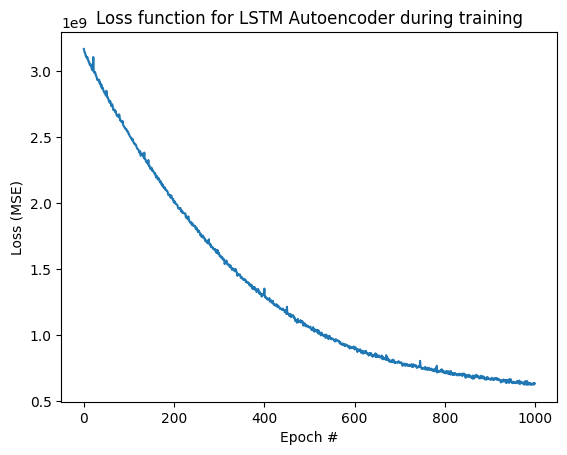

In [24]:
plt.plot(losses)
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss function for LSTM Autoencoder during training')

In [ ]:
# careful, only run this if you want to overwrite the last model

#torch.save(model.encoder.state_dict(), 'models/lstm_encoder.pth')

In [ ]:
# get the latent state representation for each timepoint, for each patient

encoder = Encoder(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
encoder.load_state_dict(torch.load('models/lstm_encoder.pth', weights_only=True))
encoder.to(device)

latent_vectors = []

for batch, lengths in dataloader:
    batch = batch.to(device) # batch: (batch_size, sequence_length, num_features)
    optimizer.zero_grad()
    latents, _ = encoder(batch, lengths, return_all_latents=True) # latents: (batch_size, sequence_length, latent_dim)
    for latent in latents: # latent: (total_num_of_timesteps_for_sequence_length_patients, latent_dim)
        latent_vectors.append(latent.detach().numpy()) # latent: (latent_dim,)

latent_vectors = np.array(latent_vectors)

print(latent_vectors.shape) # latent: (total_num_of_timesteps, latent_dim)

latent_col_names = [f'latent_{num}' for num in range(1, 21)]

latent_df = pd.DataFrame(latent_vectors, columns=latent_col_names)
latent_df.insert(0, 'icustayid', df['icustayid'])
latent_df.to_csv('data/latent_states.csv')
latent_df

In [ ]:
# visualize latent space with t-sne

latent_tsne = TSNE(n_components=2).fit_transform(latent_vectors)

latent_tsne_df = pd.DataFrame(data={
    'tsne_1': latent_tsne[:, 0],
    'tsne_2': latent_tsne[:, 1],
    'died_in_hosp': df['died_in_hosp'].values,
    'gender': df['gender'].values,
    'age': df['age'].values,
    'SOFA': df['SOFA'].values,
    'vasos': df['vaso_bin'].values,
    'IVs': df['iv_bin'].values
})

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='died_in_hosp',
    palette='Set1',
    data=latent_tsne_df,
    alpha=0.7
)
plt.title('T-SNE Plot')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend(title='died_in_hosp')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# validation

